# NYC MTA Turnstile Data Analysis
___

## 1. Data Description & Purpose
---

We will be analysing NYC MTA Turnstile dataset - which tracks passenger entries & exist from subway stations throughtout NYC.  The data is summarized at a 4 hour interval.  

[Source](http://web.mta.info/developers/turnstile.html)

[Field Descriptions](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)

The purpose of this analysis is to identify the busyness of the NYC subway system during the August to October months.  We will do this by identifying total ridership per station per day over the months of August to October (2016) timeframe.

In a prior notebook (see: nyc_mta_cleaning), we cleaned the mta dataset and placed the data into a csv.  We will import this csv and begin to explore several variables.

## 2. Import Data

 We've previously stored the data in a csv named 'nyc_mta_data_cleaned.csv'.  Let's bring this into a dataframe

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_style('white')

In [308]:
nyc_mta = pd.read_csv('./data/nyc_mta_data_cleaned.csv', parse_dates=['date'])
nyc_mta.set_index(['date', 'station', 'line', 'division'], inplace=True)

In [309]:
# take a quick look at the data
nyc_mta.head()

,,,,ridership
date,station,line,division,
2016-07-31,59 ST,NQR456,BMT,7965
2016-08-01,59 ST,NQR456,BMT,15594
2016-08-02,59 ST,NQR456,BMT,17262
2016-08-03,59 ST,NQR456,BMT,17538
2016-08-04,59 ST,NQR456,BMT,17523


In [310]:
nyc_mta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42880 entries, (2016-07-31 00:00:00, 59 ST, NQR456, BMT) to (2016-10-28 00:00:00, RIT-ROOSEVELT, R, RIT)
Data columns (total 1 columns):
ridership    42880 non-null int64
dtypes: int64(1)
memory usage: 549.2+ KB


In [311]:
nyc_mta.describe()

,ridership
count,42880.000000
mean,10247.759468
std,12470.722671
min,0.000000
25%,3564.000000
50%,6664.000000
75%,12428.000000
max,184808.000000


## 2. Exploring Ridership Per Station

What does the ridership perstation per day look like?

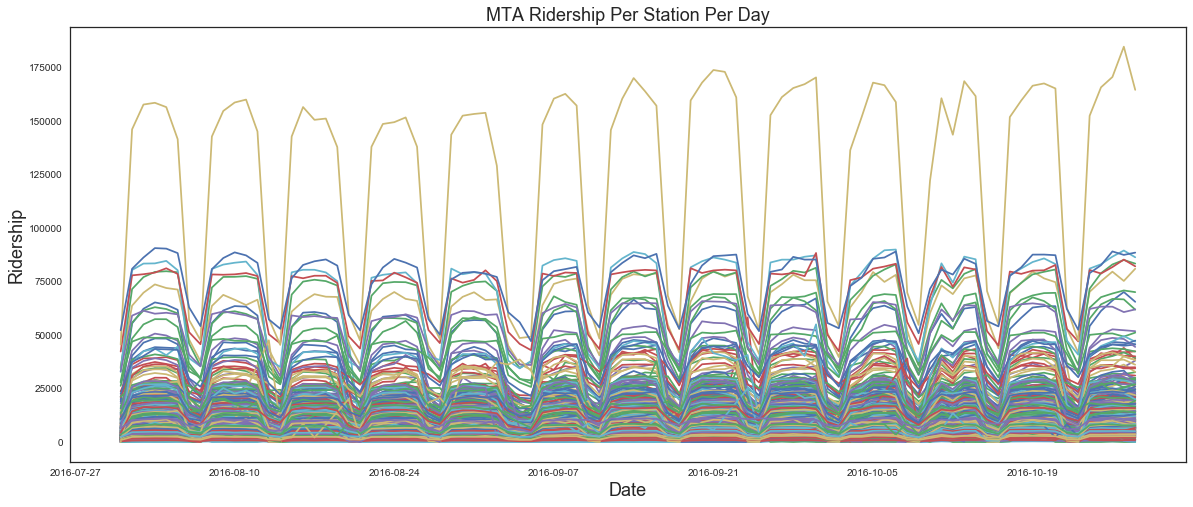

In [312]:
# set figure size
fig, ax = plt.subplots(figsize=(20,8))

# let's reset the index for plotting purposes
rps = nyc_mta.reset_index()
rps.set_index(['station', 'line', 'division'], inplace=True)

# loop through stations and plot ridership
for idx, df in rps.groupby(level=[0,1,2]):
    dates = df.date.values
    ridership = df.ridership.values
    plt.plot(dates, ridership)

# set labels
plt.title('MTA Ridership Per Station Per Day', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Ridership', fontsize=18)
fig.savefig('./figures/nyc_mta_ridership_per_station_per_day')
plt.show()


We can see that ridership as a whole has ups and downs - my expectation is that 
* The peaks we see are weekdays, and the valleys are weekends.  
* There are several stations that have majority of the ridership.  My assumption is that these are the large stations like grand central.
* Ridership begins to increas leading into September & October.  This is likely do to weather becoming cooler and less pleasant. 
* There is one dip in October during a weekday.  This is likely a reflection of the Columbus Day holiday. 

Let's continue to explore total ridership

## 3. Exploring Total Ridership

We've seen ridership per station.  What does the total riderhsip look like? 

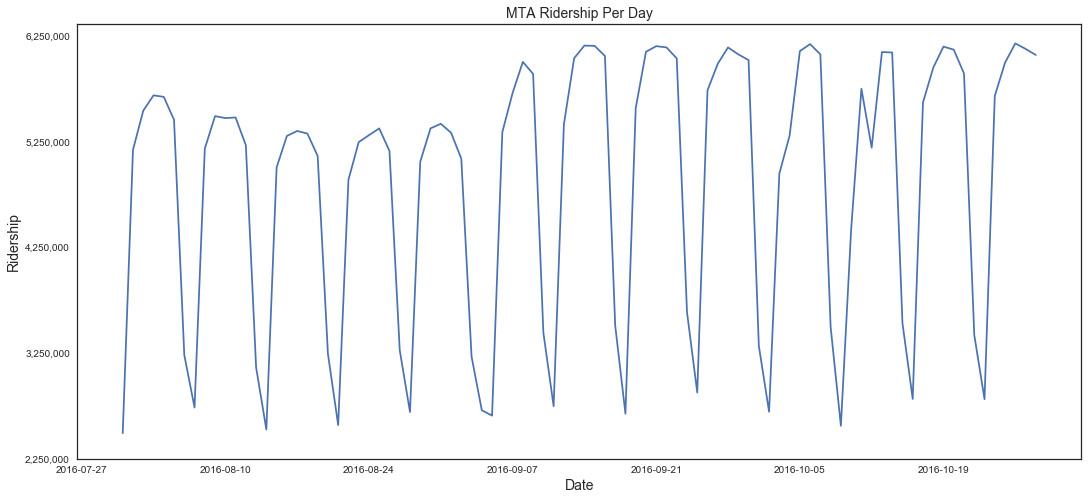

In [313]:
from collections import Counter

daily_total = Counter()

# let's reset the index for plotting purposes
tr = nyc_mta.reset_index()
tr.set_index(['date'], inplace=True)

# loop through stations and plot ridership
for idx, df in tr.groupby(level=[0]):
    daily_total[idx]+= df.ridership.sum()

# get our values to plot
dates = list(daily_total.keys())
ridership = list(daily_total.values())
    
# set figure size
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(dates, ridership)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(2250000, 6350000, 1000000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set labels
plt.title('MTA Ridership Per Day', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ridership', fontsize=14)

fig.savefig('./figures/nyc_mta_ridership_per_day')
plt.show()



Examining the total ridership per day, the peaks and valleys become very apparent.  we know:

* Ridership increases beginning september
* Ridership is significantly higher on weekdays than weekends
* Ridership is affected by holidays (Columbus Day in October)

## 4. Exploring ridership as it relates to the day of the week

We assume, based on the above graphs, that ridership is considerably higher on weekdays when compared to weekends.  What is the average ridership for each day of the week? 

In [314]:
from collections import defaultdict

def group_by_day_of_week(data):
    """
        Accepts a dictionary of ridership totals per day
        
        Summarizes the ridership per day of the week and determines
        the average ridership per day.  
    """
       
    day_of_week_total = defaultdict(list)
    day_of_week_avg = {}

    for day, count in daily_total.items():   
        day_of_week_total[day.weekday()].append(count)
    
    for i in range(7):
        day_of_week_avg[i] = sum(day_of_week_total[i]) / len(day_of_week_total[i])

    return day_of_week_avg



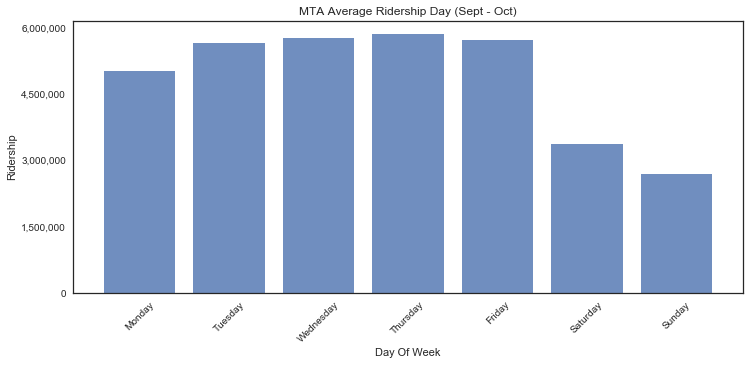

{0: 5027074.384615385, 1: 5647966.923076923, 2: 5771389.461538462, 3: 5852310.846153846, 4: 5705921.384615385, 5: 3370928.0, 6: 2685551.6153846155}


In [315]:
# find the daily averages
day_of_week_avg = group_by_day_of_week(daily_total)   

# get our data
x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = list(day_of_week_avg.keys())
counts = list(day_of_week_avg.values())

# Plot the graph
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(days, counts, alpha=0.8)

# set x ticks
#ax.set_xticklabels(x_labels)
plt.xticks(np.arange(min(days), max(days)+1, 1), x_labels, rotation=45)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add labels
plt.title('MTA Average Ridership Day (Sept - Oct)')
plt.ylabel('Ridership')
plt.xlabel('Day Of Week')

fig.savefig('./figures/nyc_mta_avg_ridership_per_day_of_week')
plt.show()

print(day_of_week_avg)

Based on the above, we can see that MTA ridership is significantly varies by day.

| Day of Week | Avg Ridership |
| ----------- | :-------------: |
| Monday      | 5,027,074.38 |
| Tuesday | 5,647,966.92 |
| Wednesday | 5,771,389.46 |
| Thursday | 5,852,310.84 |
| Friday | 5,705,921.38 |
| Saturday | 3,370,928.0 | 
| Sunday | 2,685,551.61 |

Specifically speaking towards the weekdays, Thursday's have the highest ridership, where as mondays have the lowest.  Can we prove that this?

What is the likley hood that the ridership between monday's and tuesday's is just by chance?
We will test this hypothesis below - stating our null hypothesis that the average ridership
on mondays is the same as any other weekday



In [316]:
# set our variables
mondays = nyc_mta[nyc_mta.index.get_level_values(level=0).dayofweek == 0]
tuesdays = nyc_mta[nyc_mta.index.get_level_values(level=0).dayofweek == 1]
wednesdays = nyc_mta[nyc_mta.index.get_level_values(level=0).dayofweek == 2]
thursdays = nyc_mta[nyc_mta.index.get_level_values(level=0).dayofweek == 3]
fridays = nyc_mta[nyc_mta.index.get_level_values(level=0).dayofweek == 4]

In [317]:
from scipy import stats

# monday vs tuesday
stats.ttest_ind(mondays, tuesdays)

Ttest_indResult(statistic=array([-5.58652614]), pvalue=array([  2.36537942e-08]))

In [318]:
# monday vs wednesday
stats.ttest_ind(mondays, wednesdays)

Ttest_indResult(statistic=array([-6.61108125]), pvalue=array([  3.97166493e-11]))

In [319]:
# monday vs thursdays
stats.ttest_ind(mondays, thursdays)

Ttest_indResult(statistic=array([-7.34693439]), pvalue=array([  2.15517182e-13]))

In [320]:
# monday vs fridays
stats.ttest_ind(mondays, fridays)

Ttest_indResult(statistic=array([-6.24452718]), pvalue=array([  4.38998835e-10]))

In each case above, we reject the null hypothesis and state that monday's ridership levels are not by chance, and are in fact different than other days of the week.  In each case, we recieved a very small p-value (less than 0.05) - and therefore can say that our results are statistically significant. 

## 5. Exploring Ridership Per Hour

We now know that Tuesdays to Friday appears to have the most ridership.  Are there particular times that are busier than others?

In [321]:
# We have a dataset that breaks the data down to the hour
nyc_mta_hourly = pd.read_csv('./data/nyc_mta_hourly_data_cleaned.csv', parse_dates=['date'])
nyc_mta_hourly.set_index(['date', 'station', 'line', 'division'], inplace=True)

In [322]:
nyc_mta_hourly.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 288293 entries, (2016-07-30 04:00:00, 59 ST, NQR456, BMT) to (2016-10-28 21:00:00, RIT-ROOSEVELT, R, RIT)
Data columns (total 1 columns):
ridership    288293 non-null int64
dtypes: int64(1)
memory usage: 3.9+ MB


In [323]:
# we only want to look at mondays - fridays
nyc_mta_hourly = nyc_mta_hourly[((nyc_mta_hourly.index.get_level_values(level=0).dayofweek == 1) | \
(nyc_mta_hourly.index.get_level_values(level=0).dayofweek == 2) | \
(nyc_mta_hourly.index.get_level_values(level=0).dayofweek == 3) | \
(nyc_mta_hourly.index.get_level_values(level=0).dayofweek == 4))]

In [324]:
# sort values to ensure grouping works correctly
nyc_mta_hourly.sortlevel(level=0, inplace=True)

In [325]:
# get value sum per hour
hourly = nyc_mta_hourly.groupby(level=0).ridership.sum()

In [326]:
# resample to 4hour intervals to ensure data reporting periods are correct
hourly_4h = hourly.resample(rule='4H', label='right', closed='right').sum().to_frame()

# createa new column for plotting purposes
hourly_4h['hour'] = hourly_4h.index.hour

Let's plot our ridership on the 4 hours basis per week day

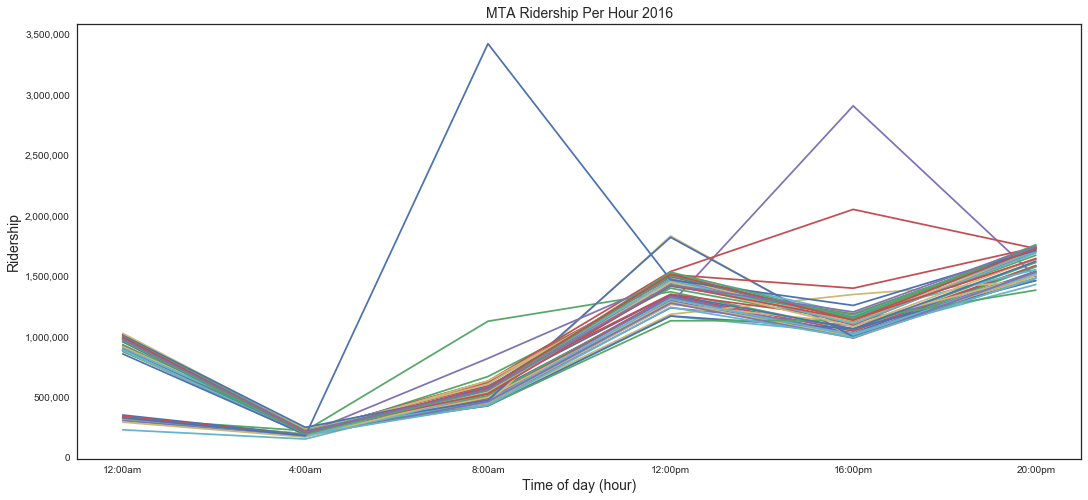

In [327]:
fig, ax = plt.subplots(figsize=(18,8))

# Loop through each day by hour index
for day, df in hourly_4h.groupby(hourly_4h.index.date):

    # get the data
    x = df.hour
    y = df.ridership
    
    # plot the data
    plt.plot(np.arange(len(x)), y)
    
# set x ticks
xaxis_lbl = ['12:00am', '4:00am', '8:00am', '12:00pm', '16:00pm', '20:00pm']
plt.xticks(range(len(xaxis_lbl)), xaxis_lbl)

# set y ticks
start, end = ax.get_ylim()
ax.set_ylim([start, end])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add labels
plt.title('MTA Ridership Per Hour 2016', fontsize=14)
plt.ylabel('Ridership', fontsize=14)
plt.xlabel('Time of day (hour)', fontsize=14)

fig.savefig('./figures/nyc_mta_ridership_per_hour')
plt.show()


Based on the graph above, we can reason the following:

1. Graphing the ridership levels by hour allows us to identify a trend within the data (see below).  The MTA data is summarized on a 4-hour interval (0, 4, 8, 12 etc).  However, upon inspecting the data futher it was found that there are turnstiles that do not follow this reporting period.  It was found that several stations (particularly on the PATH line) report on a random hour/minute/second.  In order to align the data, it was resampled to 4 hour intervals using a 'sum' aggregator.  

2. It can be noted that there are 2 reporting periods near the end of a day - 8:00pm and 2:00am (also known as 0:00hr).  Ridership from 8:01pm to 12:00am are summarized into the 0:00hr reporting period.  This is why we see such significant traffic at this early morning time (think Friday nights, or nights which have a sporting event ending after 8:00pm). 

3. Looking at the data, we do see busy periods throughout the day.  Focusing on ideal times for popup events and flash sales, retailers should target the 8:00am to 8:00pm time frame.

## 6. Exploring Average Ridership Per Month

What does the average ridership per month look like? 

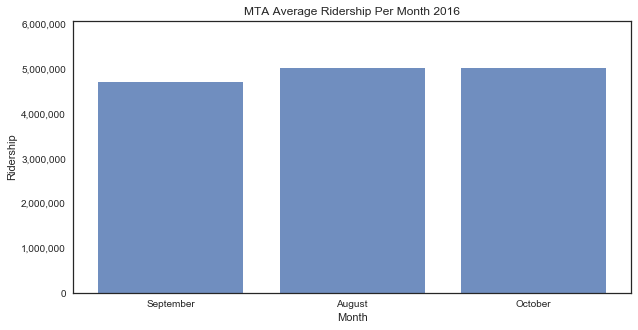

{'2016-Aug': 4700032.58, '2016-Sep': 5020936.07, '2016-Oct': 5021505.93}


In [328]:
# declare a varaible to store the averages
month_avg = {}

# loop through each month
for month in ('Aug', 'Sep', 'Oct'):

    # create the date identifier
    date = '2016-' + month
    
    # calculate the avereage
    month_avg[date] = round(nyc_mta.reset_index().set_index('date')[date].ridership.sum() \
                    / len(nyc_mta.reset_index().set_index('date')[date].index.unique()), 2)

# Plot the graph
fig, ax = plt.subplots(figsize=(10,5))

x = ['September', 'August', 'October']
y = list(month_avg.values())
ax.bar(range(len(x)),y, alpha=0.8)
plt.xticks(range(len(y)), x)

# set y ticks
start, end = ax.get_ylim()
ax.set_ylim([start, end+800000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add labels
plt.title('MTA Average Ridership Per Month 2016')
plt.ylabel('Ridership')
plt.xlabel('Month')

fig.savefig('./figures/nyc_mta_avg_ridership_per_month')
plt.show()
    
# print our results
print(month_avg)



## 7. Exploring Top Stations

What are the top 15 stations in MTA during our Aug to Sept analysis?

In [329]:
def find_station_total(data):
    """
        returns a dictionary of the total ridership per station
    """

    trps = data.reset_index()
    trps.set_index(['station', 'line', 'division'], inplace=True)

    station_totals = Counter()

    # loop through stations and plot ridership
    for idx, df in trps.groupby(level=[0,1,2]):
        station = idx 
        station_totals[station]+=df.ridership.sum()
    
    return station_totals

In [330]:
import operator

# find the station totals
st = find_station_total(nyc_mta)

# sort the totals in reverse order
sorted_st = sorted(st.items(), key=operator.itemgetter(1), reverse=True)

# print out the top 15
for x in range(15):
    print(sorted_st[x])

(('GRD CNTRL-42 ST', '4567S', 'IRT'), 11446228)
(('TIMES SQ-42 ST', '1237ACENQRS', 'IRT'), 6761915)
(('42 ST-PORT AUTH', 'ACENQRS1237', 'IND'), 6293570)
(('34 ST-PENN STA', 'ACE', 'IND'), 6260369)
(('34 ST-HERALD SQ', 'BDFMNQR', 'IND'), 5882429)
(('14 ST-UNION SQ', 'LNQR456', 'BMT'), 5712669)
(('86 ST', '456', 'IRT'), 4930670)
(('FLUSHING-MAIN', '7', 'IRT'), 4915498)
(('59 ST COLUMBUS', 'ABCD1', 'IND'), 4553229)
(('47-50 STS ROCK', 'BDFM', 'IND'), 4373001)
(('JKSN HT-ROOSVLT', 'EFMR7', 'IND'), 4010089)
(('59 ST', '456NQR', 'IRT'), 3815893)
(('W 4 ST-WASH SQ', 'ABCDEFM', 'IND'), 3436941)
(('34 ST-HERALD SQ', 'BDFMNQR', 'BMT'), 3320440)
(('42 ST-BRYANT PK', 'BDFM7', 'IND'), 3265150)


In [331]:
print('Number of stations: {}'.format(len(sorted_st)))

Number of stations: 479


We can see that Grand Central station is the top of the list.  Let's graph the results to see the top 30 stations

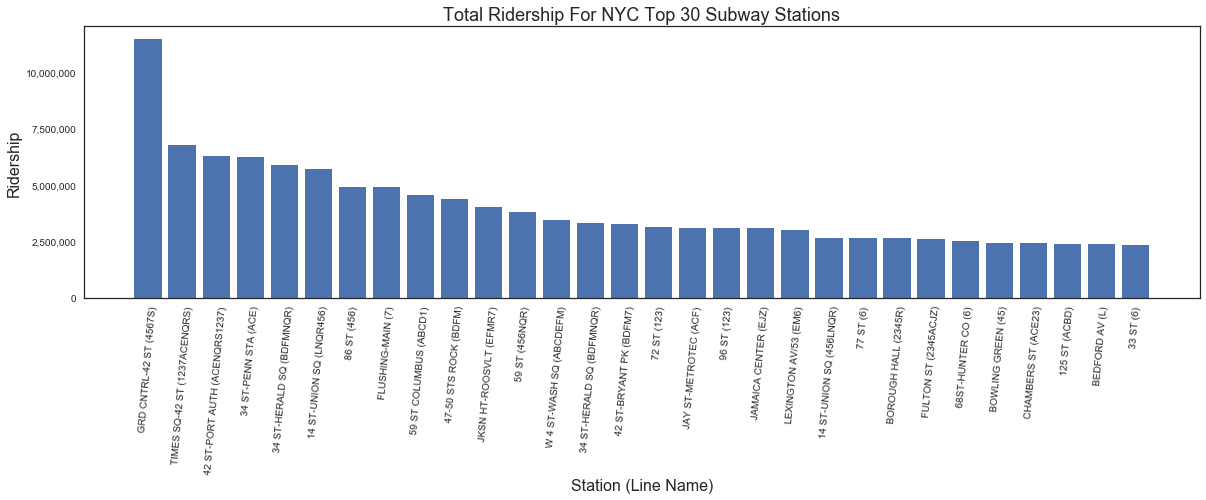

In [332]:
station_names = ['{} ({})'.format(station, line) for (station, line, div), count in sorted_st]
station_names = station_names[:30]
ridership = [count for (station, line, div), count in sorted_st]
ridership = ridership[:30]

xaxis = np.arange(len(station_names))

# Plot the graph
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(xaxis, ridership)

# set x ticks
plt.xticks(np.arange(min(xaxis), max(xaxis)+1, 1), station_names, rotation=85)

# set y ticks
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2500000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set labels
plt.title('Total Ridership For NYC Top 30 Subway Stations', fontsize=18)
plt.ylabel('Ridership', fontsize=16)
plt.xlabel('Station (Line Name)', fontsize=16)
fig.savefig('./figures/nyc_mta_top_30_stations')

plt.show()

## 8. Number of lines

How many lines do we have within this dataset?

In [333]:
# print out the number of lines
total_lines = nyc_mta.reset_index()
total_lines.division.unique()

array(['BMT', 'IND', 'PTH', 'IRT', 'SRT', 'RIT'], dtype=object)

## 9. Heatmap

In [334]:
# read in our subway locations & coordinates
nyc_mta_locations = pd.read_csv('./data/nyc_mta_locations.csv')

In [335]:
# perform a summary of ridership per station
ridership = nyc_mta.reset_index()
nyc_mta_total_ridership = ridership.groupby(['station', 'line', 'division']).ridership.sum().to_frame()
nyc_mta_total_ridership.head()

ridership
station       line division           
1 AV          L    BMT         1785966
103 ST        1    IRT         1000242
              6    IRT         1176653
              BC   IND          375422
103 ST-CORONA 7    IRT         1664840

In [336]:
# Merge the lat / long coordinates with our ridership summary
nyc_mta_total_ridership = pd.merge(nyc_mta_total_ridership, nyc_mta_locations, left_index=True, right_on=['station', 'line','division'], how='left')

# take a peek
nyc_mta_total_ridership.head()

,ridership,station,line,division,long,lat
0,1785966,1 AV,L,BMT,-73.981681,40.730975
1,1000242,103 ST,1,IRT,-73.968379,40.799446
2,1176653,103 ST,6,IRT,-73.947478,40.790600
3,375422,103 ST,BC,IND,-73.961370,40.796061
4,1664840,103 ST-CORONA,7,IRT,-73.862700,40.749865


In [337]:
# There were cases that I was not able to find coordinates for the station names - we need to drop these
nyc_mta_total_ridership.dropna(axis=0, how='any',inplace=True)

In [338]:
hm_data = []

# Create the data for the heat map - Each subway station will be represented by a list [lat, long, ridership]
for idx, row in nyc_mta_total_ridership.iterrows():
           hm_data.append([row['lat'], row['long'], row['ridership']])

In [339]:
# find out what the max number of ridership is
max_ridership = nyc_mta_total_ridership.ridership.max()

In [340]:
import folium
import folium.plugins as plugins

# Create the basemap
fmap = folium.Map(location=[40.753733, -73.983490], zoom_start = 13, tiles='cartodbpositron', max_zoom=15) 

# create the heatmap
hmap = plugins.HeatMap(hm_data, name='nyc subway ridership', max_val=float(max_ridership), max_zoom=12, min_opacity=.6)

# add the heatmap to the basemap
hmap.add_to(fmap)

# show the basemap
fmap

In [341]:
# THIS IS NOT WORKING CORRECTLY
#subway_loc = nyc_mta_total_ridership[['lat','long']].values.tolist()
#subway_names = nyc_mta_total_ridership['station'].values.tolist()
#len(subway_names)


In [342]:
# THIS IS NOT WORKING CORRECTLY

#from folium.plugins import MarkerCluster

# create the map
#map2 = folium.Map(location=[40.753733, -73.983490], zoom_start = 13, max_zoom=15) 
#Marker_cluster = MarkerCluster().add_to(map2)

#for subway in range(0, 200): #len(subway_loc)):
#    folium.Marker(subway_loc[subway], popup=subway_names[subway]).add_to(marker_cluster)

#map2

## 10. Conclusions

Historically:
* Weekdays are more likely to be busier than weekends (5.6 mil to 3.0 mil riders on avg).  If we were to target specific days - we would ideally like to target Tuesday, Wednesday, Thursday, Friday for maximum exposure.  
* Holidays have a direct impact on ridership, meaning potenitally less busy days.  It is recommended to avoid holidays for sales (September 5) (october 10)
* Ridership in September & October is greater than August.
* There are stations which have significantly larger traffic, which could be targeted over less busy areas (eg. Grand central station)

Let's identify Tuesdays, Wednesdays, Thursdays, Fridays to be our pleasant days

In [343]:
nyc_mta.reset_index(inplace=True)
nyc_mta.set_index(['date', 'station', 'line', 'division'], inplace=True)

In [344]:
# identify days which are pleasant
nyc_mta['pleasant_day'] = (nyc_mta.index.get_level_values(0).dayofweek==1) | (nyc_mta.index.get_level_values(0).dayofweek==2) | (nyc_mta.index.get_level_values(0).dayofweek==3) | (nyc_mta.index.get_level_values(0).dayofweek==4)

In [345]:
# export to file
nyc_mta.to_csv('./data/nyc_mta_pleasant_days.csv')